<a href="https://colab.research.google.com/github/yuann403/financial/blob/main/week7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mplfinance

# 1. 使用收盤價或技術指標預測，預測N日後的股價。

In [3]:
import numpy as np
import yfinance as yf
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [5]:
# 輸入股票代號
stock_id = '2330.tw'

'''今天往前算幾天'''
# 資料結束時間
end = dt.date.today()
# 抓取半年資料（現在-過去180天）
start = end - dt.timedelta(days=180)

# 參數1: 股票代號, 參數2: 開始時間, 參數3: 結束時間
df = yf.download(stock_id, start=start, end=end).reset_index()

# 將日期欄位轉為datetime格式
df["Date"] = pd.to_datetime(df["Date"])
# 將日期欄位設為索引
df.set_index("Date", inplace=True)

# 刪除 Ticker 欄位並取代
df.columns = df.columns.droplevel('Ticker')
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2024-05-03 00:00:00+00:00,773.547363,780.0,788.0,773.0,788.0,29901556
2024-05-06 00:00:00+00:00,779.497681,786.0,793.0,786.0,791.0,32599878
2024-05-07 00:00:00+00:00,793.381897,800.0,800.0,792.0,797.0,33890214
2024-05-08 00:00:00+00:00,795.365417,802.0,802.0,792.0,794.0,21757193
2024-05-09 00:00:00+00:00,789.414978,796.0,802.0,796.0,798.0,21923999


In [6]:
# 定義預測天數
N = 10  # 使用過去N天來預測未來1天

# 提取收盤價
stock_data = df['Close']

# 使用MinMaxScaler將資料標準化
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_data.values.reshape(-1, 1))

# 創建輸入和輸出數據集
def create_dataset(df, N):
  X, Y = [], []
  for i in range(len(df) - N):
    X.append(df[i:i+N, 0])
    Y.append(df[i+N, 0])
  return np.array(X), np.array(Y)

X, Y = create_dataset(scaled_data, N)

In [7]:
# 切分為訓練集（80%）和測試集（20%）
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

# 將數據轉換為 PyTorch 張量
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32).view(-1, 1)

In [8]:
# 建構 PyTorch 線性模型
class StockPredictor(nn.Module):
  def __init__(self, input_dim):
    super(StockPredictor, self).__init__()
    self.linear = nn.Linear(input_dim, 1)  # 單層線性回歸

  def forward(self, x):
    return self.linear(x)

# 創建模型實例
input_dim = N
model = StockPredictor(input_dim)

# 定義損失函數和優化器
criterion = nn.MSELoss()  # 均方誤差損失
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [9]:
# 訓練模型
num_epochs = 100
for epoch in range(num_epochs):
  model.train()

  # 前向傳播
  outputs = model(X_train)
  loss = criterion(outputs, Y_train)

  # 反向傳播和優化
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if (epoch + 1) % 10 == 0:
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.1815
Epoch [20/100], Loss: 0.0175
Epoch [30/100], Loss: 0.0447
Epoch [40/100], Loss: 0.0193
Epoch [50/100], Loss: 0.0160
Epoch [60/100], Loss: 0.0154
Epoch [70/100], Loss: 0.0136
Epoch [80/100], Loss: 0.0133
Epoch [90/100], Loss: 0.0127
Epoch [100/100], Loss: 0.0122


In [10]:
# 在測試集上進行預測
model.eval()
predicted_test = model(X_test).detach().numpy()   # 測試集的預測

# 將預測結果從標準化資料轉換回原始尺度
real_train_prices = scaler.inverse_transform(scaled_data[:train_size + N])
real_test_prices = scaler.inverse_transform(Y_test.numpy())
predicted_test_prices = scaler.inverse_transform(predicted_test)


# 調整對應的測試集日期
train_dates = df.index[:train_size + N]  # 這裡是訓練集日期範圍
test_dates = df.index[train_size + N:]  # 測試集對應的日期排除前 N 天

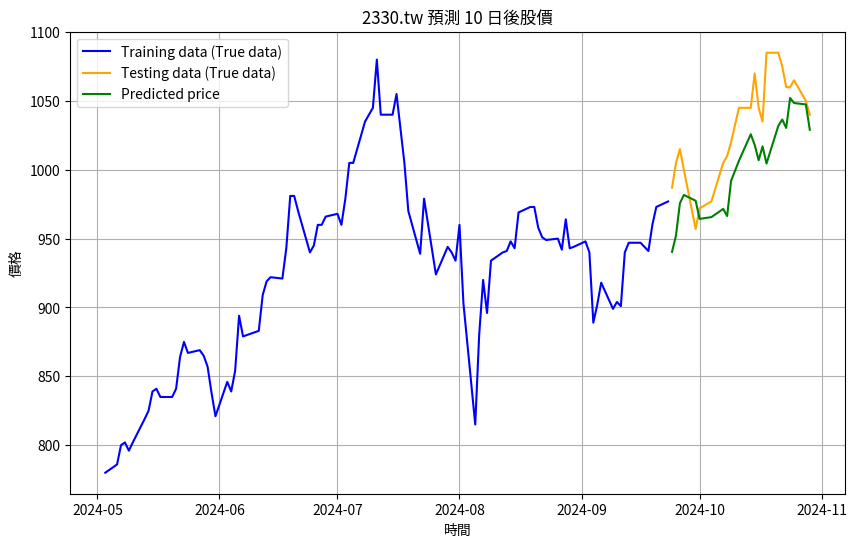

In [11]:
# 可視化結果
plt.figure(figsize=(10,6))
plt.plot(train_dates, real_train_prices, label='Training data (True data)', color='blue')
plt.plot(test_dates, real_test_prices, label='Testing data (True data)', color='orange')
plt.plot(test_dates, predicted_test_prices, label='Predicted price', color='green')
plt.title(f'{stock_id} 預測 {N} 日後股價')
plt.xlabel('時間')
plt.ylabel('價格')
plt.legend()
plt.grid(True)
plt.show()

#2. 實作 CNN 捕捉 K 線趨勢，並預測股價漲跌（分類任務）

In [12]:
# 輸入股票代號
stock_id = '2330.tw'

'''今天往前算幾天'''
# 資料結束時間
end = dt.date.today()
# 抓取半年資料（現在-過去180天）
start = end - dt.timedelta(days=180)

# 參數1: 股票代號, 參數2: 開始時間, 參數3: 結束時間
df = yf.download(stock_id, start=start, end=end).reset_index()

# 將日期欄位轉為datetime格式
df["Date"] = pd.to_datetime(df["Date"])
# 將日期欄位設為索引
df.set_index("Date", inplace=True)

# 刪除 Ticker 欄位並取代
df.columns = df.columns.droplevel('Ticker')
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2024-05-03 00:00:00+00:00,773.547363,780.0,788.0,773.0,788.0,29901556
2024-05-06 00:00:00+00:00,779.497681,786.0,793.0,786.0,791.0,32599878
2024-05-07 00:00:00+00:00,793.381897,800.0,800.0,792.0,797.0,33890214
2024-05-08 00:00:00+00:00,795.365417,802.0,802.0,792.0,794.0,21757193
2024-05-09 00:00:00+00:00,789.414978,796.0,802.0,796.0,798.0,21923999


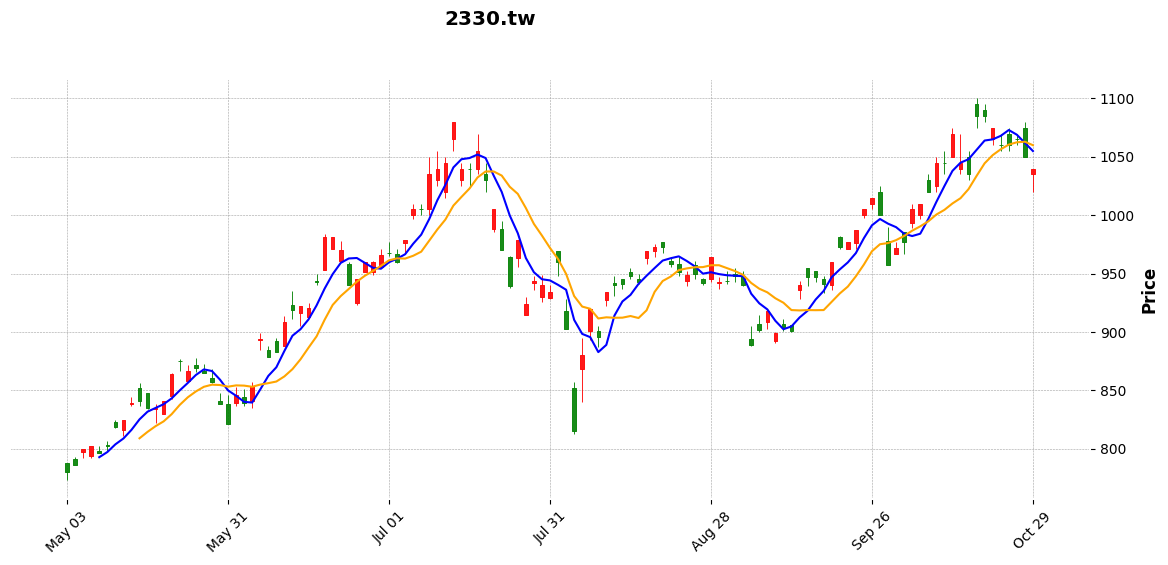

In [13]:
import mplfinance as mpf

# 設置 K 線繪圖風格，漲為紅色，跌為綠色
my_color = mpf.make_marketcolors(up='r', down='g', inherit=True)
my_style = mpf.make_mpf_style(base_mpf_style='charles', marketcolors=my_color)

# 計算 5 日和 10 日均線
df['5_MA'] = df['Close'].rolling(window=5).mean()
df['10_MA'] = df['Close'].rolling(window=10).mean()

# 設定兩條均線的顏色
add_plots = [
    mpf.make_addplot(df['5_MA'], color='blue', width=1.5),
    mpf.make_addplot(df['10_MA'], color='orange', width=1.5)
]

# 繪製 K 線圖並添加均線
mpf.plot(df,
         type='candle',
         style=my_style,
         title=f'{stock_id}',
         figsize=(15, 6),
         addplot=add_plots)

# 保存帶有不同顏色均線的 K 線圖
mpf.plot(df,
         type='candle',
         style=my_style,
         title=f'{stock_id}',
         figsize=(15, 6),
         addplot=add_plots,
         savefig='k_line.png')

In [14]:
from PIL import Image # 處理圖像資料
import random # 隨機
import os # 系統檔，讀取資料使用

window_size = 30  # K線圖的時間窗口

# 定義短期和長期均線的週期
short_window = 5
long_window = 20

# K線圖保存的文件夹
output_dir = 'k_line_images'
if not os.path.exists(output_dir):
  os.makedirs(output_dir)

# 儲存標籤
labels = []
file_names = []

# 切片數據並生成標籤和 K 線圖
for i in range(len(df) - window_size):
  window_data = df.iloc[i:i + window_size]  # 當前 K 線圖窗口

  # 計算短期均線和長期均線
  short_ma = window_data['Close'].rolling(window=short_window).mean().iloc[-1]
  long_ma = window_data['Close'].rolling(window=long_window).mean().iloc[-1]

  print(f'窗口{i}的短期均線: {short_ma}, 長期均線: {long_ma}, 標記為', end='')

  # 判斷漲跌：短期均線高於長期均線則標記為漲，否則標記為跌
  if short_ma > long_ma:
    labels.append(1)  # 漲
    print('「漲」: 1')
  else:
    labels.append(0)  # 跌
    print('「跌」: 0')

  print('\n--------------------------------\n')

  # 生成文件名
  file_name = f'k_line_{i}.png'
  file_names.append(file_name)

  # 保存 K 線圖
  mpf.plot(window_data, type='candle', style=my_style, axisoff=True,
             figsize=(15, 6), savefig=os.path.join(output_dir, file_name))

# 保存標籤到 CSV 文件中
labels_df = pd.DataFrame({
    'file_name': file_names,
    'label': labels
})

labels_df.to_csv('labels.csv', index=False)

窗口0的短期均線: 902.4, 長期均線: 865.6, 標記為「漲」: 1

--------------------------------

窗口1的短期均線: 910.8, 長期均線: 869.9, 標記為「漲」: 1

--------------------------------

窗口2的短期均線: 922.8, 長期均線: 875.3, 標記為「漲」: 1

--------------------------------

窗口3的短期均線: 937.2, 長期均線: 882.3, 標記為「漲」: 1

--------------------------------

窗口4的短期均線: 949.6, 長期均線: 888.15, 標記為「漲」: 1

--------------------------------

窗口5的短期均線: 959.2, 長期均線: 892.9, 標記為「漲」: 1

--------------------------------

窗口6的短期均線: 963.0, 長期均線: 896.55, 標記為「漲」: 1

--------------------------------

窗口7的短期均線: 963.4, 長期均線: 900.35, 標記為「漲」: 1

--------------------------------

窗口8的短期均線: 959.2, 長期均線: 905.1, 標記為「漲」: 1

--------------------------------

窗口9的短期均線: 955.0, 長期均線: 910.25, 標記為「漲」: 1

--------------------------------

窗口10的短期均線: 954.2, 長期均線: 916.65, 標記為「漲」: 1

--------------------------------

窗口11的短期均線: 959.8, 長期均線: 924.0, 標記為「漲」: 1

--------------------------------

窗口12的短期均線: 962.8, 長期均線: 929.7, 標記為「漲」: 1

--------------------------------

窗口13的短期均線: 966.6,

In [15]:
# 顯示漲跌數據筆數
labels_df['label'].value_counts()

,count
label,
1,66
0,25


In [16]:
labels_df['label'] = labels_df['label'].astype(str)

In [17]:
from sklearn.model_selection import train_test_split

# 先從原始資料中切分出測試集 (20%)
train_df, test_df = train_test_split(labels_df, test_size=0.2, stratify=labels_df['label'], random_state=100)
# 再把訓練集劃分成訓練集與驗證集 (80%，20%)
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=100)

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# K線圖位置路徑
image_dir = 'k_line_images/'

# 建立資料集生成器
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,    # 隨機選轉
    width_shift_range=0.1,  # 水平平移
    height_shift_range=0.1, # 垂直平移
    zoom_range=0.1,     # 隨機縮放
    horizontal_flip=True,  # 水平翻轉
    validation_split=0.2)  # 20% 當驗證集

In [19]:
# 訓練集生成器
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,
    x_col="file_name",
    y_col="label",
    target_size=(150, 150),
    batch_size=8,
    class_mode='binary'
)

# 驗證集生成器
validation_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=image_dir,
    x_col="file_name",
    y_col="label",
    target_size=(150, 150),
    batch_size=8,
    class_mode='binary'
)

Found 57 validated image filenames belonging to 2 classes.
Found 15 validated image filenames belonging to 2 classes.


In [20]:
# 測試集生成器
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=image_dir,
    x_col="file_name",
    y_col="label",
    target_size=(150, 150),
    batch_size=8,
    class_mode='binary',
    shuffle=False  # 測試集不需要隨機打亂
)

Found 19 validated image filenames belonging to 2 classes.


In [21]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential # 模型容器
from tensorflow.keras.layers import (
    Input,    # 輸入層
    Conv2D,    # 卷積層
    MaxPooling2D, # 最大池化層
    Flatten,   # 展平層
    Dense,    # 全連接層
    LeakyReLU,  # 避免梯度消失
    Dropout,   # 避免過擬合
    BatchNormalization # 批次正規化
)
from tensorflow.keras.optimizers import Adam # 模型優化器
from tensorflow.keras.callbacks import ReduceLROnPlateau # 動態調整學習率

# 設定學習率動態調整
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

# 建立模型容器
model = Sequential()

model.add(Input(shape=(150, 150, 3)))

# 第一層卷積層 + 批次歸一化 + LeakyReLU + 最大池化
model.add(Conv2D(32, (5, 5)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPooling2D((2, 2)))

# 第二層卷積層 + 批次歸一化 + LeakyReLU + 最大池化
model.add(Conv2D(64, (5, 5)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPooling2D((2, 2)))

# 第三層卷積層 + 批次歸一化 + LeakyReLU + 最大池化
model.add(Conv2D(128, (3, 3)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPooling2D((2, 2)))

# 加入 Dropout 層來防止過擬合
model.add(Dropout(0.2))

# 展平層
model.add(Flatten())

# 全連接層 + LeakyReLU
model.add(Dense(128))
# 加入 Dropout 層
model.add(Dropout(0.2))

model.add(Dense(64))
# 加入 Dropout 層
model.add(Dropout(0.2))

# 輸出層（使用 sigmoid 進行二元分類）
model.add(Dense(1, activation='sigmoid'))

# 編譯模型
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [22]:
# 模型訓練
hist = model.fit(
    train_generator,  # 訓練集生成器
    validation_data=validation_generator,  # 驗證集生成器
    epochs=30,  # 訓練週期
    callbacks=[reduce_lr]  # 使用動態調整學習率的回调函數
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 752ms/step - accuracy: 0.6467 - loss: 5.0255 - val_accuracy: 0.7333 - val_loss: 0.4870 - learning_rate: 0.0010
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 857ms/step - accuracy: 0.7285 - loss: 12.2528 - val_accuracy: 0.8667 - val_loss: 0.3338 - learning_rate: 0.0010
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 666ms/step - accuracy: 0.7266 - loss: 7.8317 - val_accuracy: 0.7333 - val_loss: 0.8362 - learning_rate: 0.0010
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 665ms/step - accuracy: 0.7009 - loss: 8.1643 - val_accuracy: 0.7333 - val_loss: 1.1745 - learning_rate: 0.0010
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 670ms/step - accuracy: 0.7833 - loss: 12.1987 - val_accuracy: 0.4000 - val_loss: 0.9076 - learning_rate: 0.0010
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 945ms/step - accuracy: 0.6684 - loss: 11.1576 - val_accuracy: 0.7333 - val_loss: 0.7382 - learning_rate: 2.0000e-04
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 677ms/step - accuracy: 0.8111 - loss: 3.8420 - val_accuracy: 

In [23]:
# 測試模型
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step - accuracy: 0.7434 - loss: 2.2326
Test accuracy: 0.7368420958518982


In [24]:
# 獲取一批測試集圖片
test_images, test_labels = next(test_generator)
# 預測測試集
predictions = model.predict(test_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


實際結果： 漲
預測結果： 漲


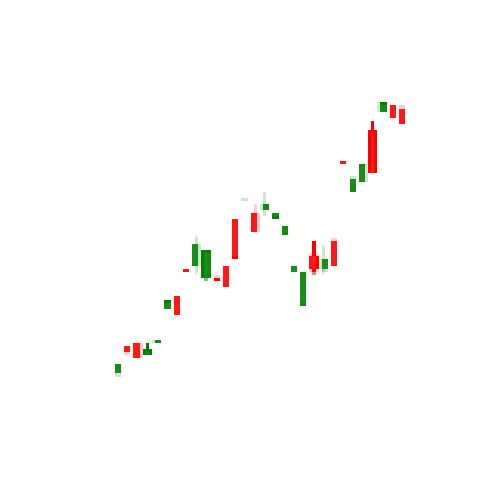

In [25]:
print('實際結果：', '漲' if test_labels[0] == 1 else '跌') # 實際標籤 0 為跌 1 為漲
print('預測結果：', '漲' if predictions[0] > 0.5 else '跌') # Sigmoid 0.5 為閾值

plt.figure(figsize=(15, 6))
plt.imshow(test_images[0])
plt.axis('off')
plt.show()

# 在 Colab 上使用中文字體

In [2]:
# Colab 進行matplotlib繪圖時顯示繁體中文
# 下載台北思源黑體並命名taipei_sans_tc_beta.ttf，移至指定路徑
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

import matplotlib

# 改style要在改font之前
# plt.style.use('seaborn')

matplotlib.font_manager.fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
matplotlib.rc('font', family='Taipei Sans TC Beta')

--2024-10-30 07:38:48--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 172.253.63.102, 172.253.63.139, 172.253.63.101, ...
Connecting to drive.google.com (drive.google.com)|172.253.63.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2024-10-30 07:38:48--  https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.16.132, 2607:f8b0:4004:c17::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.16.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20659344 (20M) [application/octet-stream]
Saving to: ‘TaipeiSansTCBeta-Regular.ttf’

TaipeiSansTCBeta-Re 100%[===================>]  19.70M   114MB/s    in 0.2s    

2024-10-30 07:38: